In [ ]:
!pip install wordcloud unidecode nltk

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from unidecode import unidecode
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ffer2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ffer2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 0.Carga y explocarción de datos

Vamos a usar tweets de política para intentar realizar un ejercicio de clasificación múltiple.

Fuente de datos:https://www.kaggle.com/datasets/ricardomoya/tweets-poltica-espaa

In [ ]:
# Cargarmos el archivo separado por tabulador (antes eliminar una fila vacía)
df = pd.read_csv('tweets_politica_kaggle.csv', sep='\t')
df.head()

,cuenta,partido,timestamp,tweet
0,a34133350b0605cb24081843f63176ca,psoe,1.363973e+09,@vesteve3 @manubenas @ccoo_rm @desobediencia_ ...
1,a34133350b0605cb24081843f63176ca,psoe,1.364061e+09,"“@kirovast: @Hugo_Moran muy fan de la ""radical..."
2,a34133350b0605cb24081843f63176ca,psoe,1.364117e+09,@ALTAS_PRESIONES Nuevos dueños para las renova...
3,a34133350b0605cb24081843f63176ca,psoe,1.364121e+09,@jumanjisolar @solartradex @josea_dolera El di...
4,a34133350b0605cb24081843f63176ca,psoe,1.364153e+09,“@cesarnayu: https://t.co/J4OTXj1x7w … Por fav...


In [ ]:
# Seleccionamos las columnas con las que vamos a trabajar
df = df[['partido','tweet']]

In [ ]:
# Tweets por cada partido
df.partido.value_counts()

psoe          61404
vox           51505
podemos       48808
pp            45481
ciudadanos    38592
Name: partido, dtype: int64

El dataset está desbalanceado 61.404 tweets de la categoría psoe frente a 38.592 tweets de la categoría ciudadanos. Dado que contamos con un gran volumen de datos podemos permitirnos realizar **downsampling** para equilibrar el dataset de modo que haya la misma cantidad de tweets de cada partido.

In [ ]:
# Contar la frecuencia de cada clase y obtener la frecuencia mínima entre las clases
frecuencia_minima = df['partido'].value_counts().min()

# Crear una muestra ponderada según la frecuencia de la clase minoritaria
df = df.groupby('partido').apply(lambda x: x.sample(frac=frecuencia_minima / len(x))).reset_index(drop=True)
df.head()

,partido,tweet
0,ciudadanos,Madrid vuelve a convertirse en capital del ten...
1,ciudadanos,Mi más enérgica condena al atentado que han su...
2,ciudadanos,@MarioGarcesSan qué momentos bonitos dejan a v...
3,ciudadanos,Mientras Sánchez se negaba a firmar con la opo...
4,ciudadanos,Mañueco dice que es complicado respetar a quie...


In [ ]:
# Comporbamos que ahora nuestro dataset esté balanceado
df.partido.value_counts()

ciudadanos    38592
podemos       38592
pp            38592
psoe          38592
vox           38592
Name: partido, dtype: int64

In [ ]:
# Total de tweets
print(f'El dataset se compone de un total de {df.shape[0]} tweets.')

El dataset se compone de un total de 192960 tweets.


In [ ]:
# Comprobación de posibles tweets duplicados
print(f'Número de tweets duplicados: {df.duplicated().sum()}')

Número de tweets duplicados: 439


In [ ]:
# Eliminar duplicados
df.drop_duplicates(inplace=True)
print(f'El dataset se compone de un total de {df.shape[0]} tweets.')

El dataset se compone de un total de 192521 tweets.


In [ ]:
# Comprobación de valores faltantes
df['tweet'].isna().sum()

0

In [ ]:
# Muestra aleatoria de los tweets
df.sample(5).tweet.values

array(['🎙 @santicl en @radioeuskadi Ofrecemos diálogo y programa electoral.Los socialistas tenemos experiencia en el acuerdo. Nuestro objetivo es dar estabilidad y certeza al país.#HicisteisQuePasara https://t.co/pADrBrrwmV',
       'No se puede convertir un día de tolerancia en un acto de intolerancia. Muchas personas vinieron a apoyarnos porque no se sienten representadas por las agresiones de un grupo minoritario de radicales y sectarios. ¡El Orgullo es libertad y es de todos! https://t.co/2aZlAHYALx',
       'La lucha contra la Crisis Climática también incluye la lucha por la igualdad y la justicia social.Sin una agenda de género, con visión transversal en las medidas, no conseguiremos frenar la Emergencia Climática y asegurarnos un futuro. #COP25Madridhttps://t.co/wP0bB3yFlk',
       'La cesta de la compra cada vez está más cara, y las rentas medias y bajas siguen perdiendo poder adquisitivo.No se puede entender por qué el Gobierno se sigue negando a bajar el IVA del pescado, la c

# 1.Preprocesado del texto

Depende del problema en el que trabajemos necesitaremos adaptar el preprocesamiento de los textos. El objetivo en general suele ser reducir el ruido y las "impurezas" que se dan en el lenguaje natural de modo que se obtenga una versión normalizada del texto. A continuación se muestra una aproximación genérica:

In [ ]:
# Definición de función encargada de la limpieza y normalización
def preprocess_tweet(text):
    # Texto a minúscula
    text = text.lower()
    # Eliminación de las urls
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Eliminación de las menciones
    text = re.sub(r'@\w+', '', text)
    # Eliminación de hashtags
    text = re.sub(r'#\w+', '', text)
    # Solo texto
    text = re.sub(r'[^\w\s]|[\d]', '', text)
    # Eliminación de los espacios adicionales
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenización del texto
    tokens = word_tokenize(text)
    # Eliminación de los acentos
    tokens = [unidecode(token) for token in tokens]
    # Eliminación de las stopwords
    stop_words = set(stopwords.words('spanish'))
    tokens = [token for token in tokens if token not in stop_words]
    # Lematización de palabras
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Eliminación de palabras cortas para reducir el vocabulario
    tokens = [token for token in tokens if len(token)>3]
    return ' '.join(tokens)

In [ ]:
# Ejemplo de aplicación de la función de preprocesado para un tweet aleatorio
tweet_aleatorio = df.sample(1).tweet.values[0]
print(f'Tweet antes de ser preprocesado:\n {tweet_aleatorio}')
tweet_aleatorio_prepro = preprocess_tweet(tweet_aleatorio)
print('-'*50)
print(f'Tweet tras ser preprocesado:\n {tweet_aleatorio_prepro}')

Tweet antes de ser preprocesado:
 ❌ El adelanto electoral es una irresponsabilidad en mitad de una pandemia.👉 Es momento de pensar en la ciudadanía, no en el rédito político. 📡 @BalEdmundo #ActualidadCs https://t.co/7o2yCrxUVT
--------------------------------------------------
Tweet tras ser preprocesado:
 adelanto electoral irresponsabilidad mitad pandemia momento pensar ciudadania redito politico


In [ ]:
# Aplicamos el preprocesado a todos los textos del dataset
df['tweet_prepro'] = df.tweet.progress_apply(preprocess_tweet)

100%|██████████| 192521/192521 [06:02<00:00, 531.28it/s]


# 2.Exploración de los textos normalizados

Tras normalizar es probable que volvamos a encontrar tweets duplicados, también puede ser interesante estudiar el número de palabras que compone cada tweet así como las palabras que aparecen con más frecuencia en los tweets de cada partido.

In [ ]:
# Comprobación de posibles tweets duplicados
print(f'Número de tweets duplicados: {df.tweet_prepro.duplicated().sum()}')

Número de tweets duplicados: 11721


In [ ]:
# Eliminar tweets que tras ser preprocesados han quedado igual
df.drop_duplicates(subset='tweet_prepro', inplace=True)
print(f'El dataset se compone de un total de {df.shape[0]} tweets.')

El dataset se compone de un total de 180800 tweets.


In [ ]:
# Comprobación de valores faltantes
df['tweet_prepro'].isna().sum()

0

In [ ]:
# Aplicamos el conteo de palabras
df['word_count'] = df.tweet_prepro.progress_apply(lambda x:len(x.split()))

100%|██████████| 180800/180800 [00:01<00:00, 165820.14it/s]


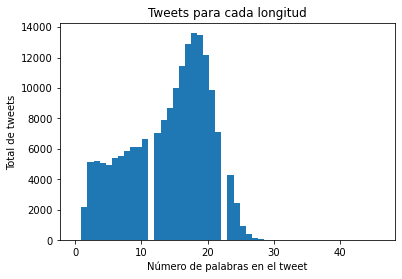

In [ ]:
# Número de tweets de cada longitud
plt.hist(df.word_count, bins=50)
plt.title('Tweets para cada longitud')
plt.xlabel('Número de palabras en el tweet')
plt.ylabel('Total de tweets')
plt.show()

In [ ]:
# Seleccionar tweets con más de 10 palabras y menos de 25
df_sel = df[(df.word_count>10)&(df.word_count<25)]
len(df_sel)

127627

In [ ]:
# Tweets por cada partido
df_sel.partido.value_counts()

ciudadanos    28878
podemos       27579
psoe          25710
pp            24434
vox           21026
Name: partido, dtype: int64

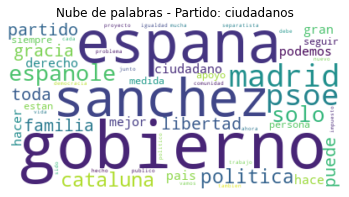

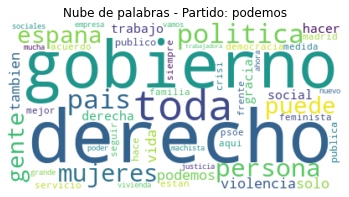

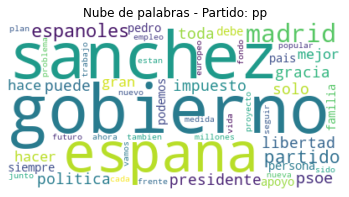

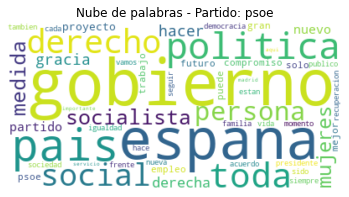

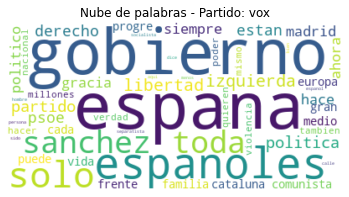

In [ ]:
# Crear una lista de partidos únicos en el DataFrame
partidos_unicos = df_sel['partido'].unique()

# Para cada partido generar una nube de palabras
for partido in partidos_unicos:
    textos_partido = " ".join(df_sel[df_sel['partido'] == partido]['tweet_prepro'].tolist())
    wordcloud = WordCloud(background_color="white", max_words=50, contour_color="steelblue", collocations=False)
    wordcloud.generate(textos_partido)
    # Mostrar la nube de palabras para cada partido
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Nube de palabras - Partido: {partido}")
    plt.axis("off")
    plt.show()

# 3.Procesamiento del dato


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_sel.tweet_prepro, df_sel.partido, test_size=0.2, random_state=42)

In [ ]:
# Crear una instancia del LabelEncoder
label_encoder = LabelEncoder()

# Ajustar y transformar la columna 'partido' con el LabelEncoder
y_train_label = label_encoder.fit_transform(y_train)
y_test_label = label_encoder.transform(y_test)

In [ ]:
# Crear la versión vectorizada de los textos desechando palabras que aparezcan en menos del 0.1% de los documentos
vectorizer = TfidfVectorizer(min_df=0.001)
X_train_num = vectorizer.fit_transform(X_train)
X_test_num = vectorizer.transform(X_test)

In [ ]:
len(X_train)*0.001

102.101

In [ ]:
vectorizer.get_feature_names_out()

array(['abajo', 'abalos', 'abandonar', ..., 'zapatero', 'zaragoza',
       'zona'], dtype=object)

In [ ]:
X_train_num.toarray().shape

(102101, 2790)

# 4.Modelización y métricas

In [ ]:
clf = LogisticRegression().fit(X_train_num.toarray(), y_train_label)
y_pred = clf.predict(X_test_num.toarray())
print(classification_report(y_test_label, y_pred, target_names=label_encoder.classes_))

C:\Users\ffer2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

  ciudadanos       0.60      0.60      0.60      5782
     podemos       0.64      0.68      0.66      5615
          pp       0.57      0.53      0.55      4869
        psoe       0.58      0.60      0.59      5074
         vox       0.62      0.59      0.61      4186

    accuracy                           0.60     25526
   macro avg       0.60      0.60      0.60     25526
weighted avg       0.60      0.60      0.60     25526



In [ ]:
y_pred_train = clf.predict(X_train_num.toarray())
print(classification_report(y_train_label, y_pred_train, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

  ciudadanos       0.64      0.63      0.64     23096
     podemos       0.67      0.72      0.69     21964
          pp       0.61      0.57      0.59     19565
        psoe       0.63      0.64      0.64     20636
         vox       0.66      0.63      0.65     16840

    accuracy                           0.64    102101
   macro avg       0.64      0.64      0.64    102101
weighted avg       0.64      0.64      0.64    102101



El rendimiento obtenido por el modelo basado en regresión logística es algo mejor que el puro azar, además no se observa un gran error de generalización.

# Extra

El mundo del procesamiento de texto NLP es muy amplio y sus aplicaciones abarcan:

- Clasficación de texto.
- Reconocimiento de entidades y reconocimiento de entidades linkadas (NER/NEL).
- Traducción automática (Transformers).
- Resúmenes (Extractivo/Abstractivo).
- Respuestas a preguntas de documentos (QA).
- Etc.

En este notebook hemos visto un caso práctico de clasificación de texto. A continuación se muestra un ejemplo de uso de LLM de HuggingFace para resumir texto:

In [ ]:
!pip install transformers

     -------------------------------------- 123.5/123.5 kB 2.4 MB/s eta 0:00:00
   ---------------------------------------- 7.9/7.9 MB 9.2 MB/s eta 0:00:00
   ---------------------------------------- 311.7/311.7 kB 9.4 MB/s eta 0:00:00
   --------------------------------------- 277.2/277.2 kB 17.8 MB/s eta 0:00:00
   ---------------------------------------- 2.2/2.2 MB 7.8 MB/s eta 0:00:00
   ---------------------------------------- 166.4/166.4 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2022.2.0
    Uninstalling fsspec-2022.2.0:
      Successfully uninstalled fsspec-2022.2.0


In [ ]:
import transformers
from transformers import pipeline

In [ ]:
# https://www.bbc.com/mundo/articles/cv2ze5xzn8wo
texto = """En 1976, un agricultor local llamado Tomás Serrano comenzó a tropezar con lo que parecían restos fosilizados en sus campos.
Reconociendo el potencial que tenían sus descubrimientos de ser importantes, se los mostró a sus vecinos y familiares, explicándoles que había encontrado 'piedras que parecen huesos'.
Cuando se puso en contacto con las autoridades locales, no le dieron mucha importancia a sus hallazgos. Pero cuando tres miembros del Instituto Catalán de Paleontología viajaron más tarde a la zona y examinaron los hallazgos de Serrano, confirmaron que su corazonada era correcta: no se trataba de piedras ordinarias.
La finca de Serrano y sus alrededores pronto se convirtieron en un sitio arqueológico en funcionamiento, y cuando un equipo de expertos descendió cerca de Orce en los años siguientes, descubrió una presencia continua de restos fosilizados de grandes mamíferos que datan de aproximadamente 1,5 a 1,6 millones de años.
Esta capa fósil se formó en un entorno de charcas de agua dulce, cerca del antiguo lago de Orce-Baza, donde los huesos fueron depositados y enterrados en el barro calcáreo que los cubría."""

In [ ]:
summarizer = pipeline("summarization")
summarized = summarizer(texto, min_length=75, max_length=300)

No model was supplied, defaulted to t5-small and revision d769bba (https://huggingface.co/t5-small).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

C:\Users\ffer2\anaconda3\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ffer2\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [ ]:
print(summarized)

[{'summary_text': 'agricultor llamado Tomás Serrano camenzó a tropezar con lo que parecan restos fosilizados en sus campos . cuando se puso en contacto con las autoridades locales, no le dieron mucha importancia a sus hallazgos de serrano .'}]


In [ ]:
print(summarized[0]['summary_text'])

agricultor llamado Tomás Serrano camenzó a tropezar con lo que parecan restos fosilizados en sus campos . cuando se puso en contacto con las autoridades locales, no le dieron mucha importancia a sus hallazgos de serrano .
